In [1]:
from pedpy import load_trajectory
from pedpy import (
    Geometry,
    TrajectoryUnit,
    get_invalid_trajectory,
    is_trajectory_valid,
)
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely import LineString, Polygon
import warnings

warnings.filterwarnings("ignore")

# Setup geometry & measurement area

## Prepare geometry

In [2]:
geometry_poly = Polygon([(-10, -3), (-10, 8), (10, 8), (10, -3)])

geometry = Geometry(walkable_area=geometry_poly)
geometry.add_obstacle(Polygon([(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)]))
geometry.add_obstacle(Polygon([(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)]))

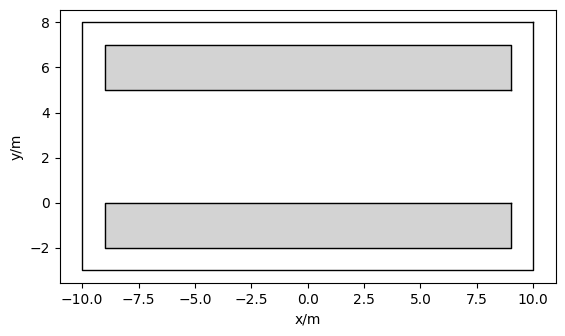

In [3]:
from pedpy.plotting.plotting import plot_geometry

plot_geometry(geometry=geometry, hole_color="lightgrey").set_aspect("equal")

## Prepare measurement details

In [4]:
ma = Polygon([(-1.5, 0), (-1.5, 5), (1.5, 5), (1.5, 0), (-1.5, 0)])
ml = LineString([(0, 0), (0, 5)])
passing_offset = 1.0

direction = np.array([-1, 0])

## Load trajectories

In [5]:
traj = load_trajectory(
    trajectory_file=pathlib.Path(
        "demos/uni-directional/traj_UNI_CORR_500_01.txt"
    ),
    default_unit=TrajectoryUnit.METER,
    # needs to be provided as it not defined in the file
    # default_frame_rate=25., # can be ignored here as the frame rate is defined in the file
)

## Plot setup

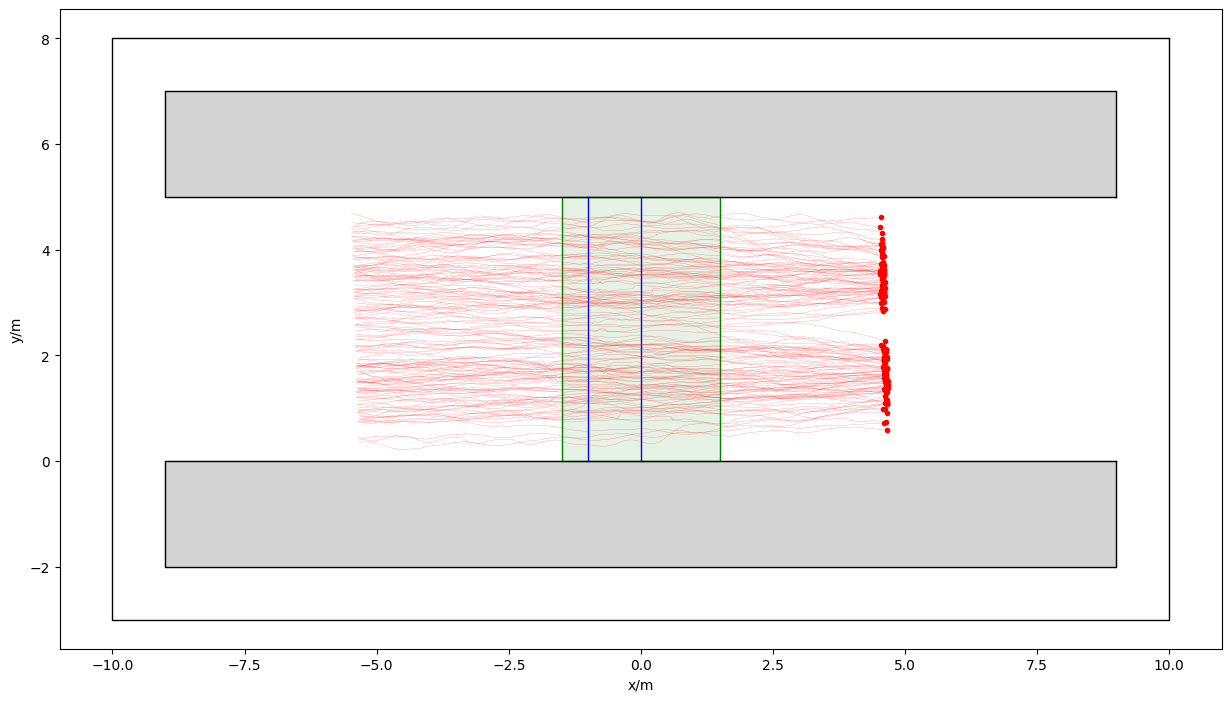

In [6]:
from pedpy import plot_measurement_setup

fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(111, aspect="equal")

plot_measurement_setup(
    traj=traj,
    geometry=geometry,
    measurement_areas=[ma],
    measurement_lines=[ml, shapely.offset_curve(ml, passing_offset)],
    traj_width=0.1,
    traj_start_marker=".",
    hole_color="lightgrey",
    ml_color="b",
    ma_color="g",
    ma_alpha=0.1,
    ma_line_color="g",
    ax=ax1,
)
plt.show()

# Velocity

## Different movement methods

In [9]:
def compute_movement_current(traj_data: pd.DataFrame, frame_step: int):
    df_movement = traj_data.copy(deep=True)

    df_movement["start"] = (
        df_movement.groupby("ID")["points"]
        .shift(frame_step)
        .fillna(df_movement["points"])
    )
    df_movement["start_frame"] = (
        df_movement.groupby("ID")["frame"]
        .shift(frame_step)
        .fillna(df_movement["frame"])
    )

    df_movement["end"] = (
        df_movement.groupby("ID")["points"]
        .shift(-frame_step)
        .fillna(df_movement["points"])
    )
    df_movement["end_frame"] = (
        df_movement.groupby("ID")["frame"]
        .shift(-frame_step)
        .fillna(df_movement["frame"])
    )
    return df_movement[
        ["ID", "frame", "start", "end", "start_frame", "end_frame"]
    ]

In [14]:
def compute_movement_cutting(
    traj_data: pd.DataFrame, frame_step: int, bidirectional: bool = True
):
    df_movement = traj_data.copy(deep=True)

    df_movement["start"] = (
        df_movement.groupby("ID")["points"]
        .shift(frame_step)
    )
    df_movement["start_frame"] = (
        df_movement.groupby("ID")["frame"]
        .shift(frame_step)
    )

    df_movement["end"] = (
        df_movement.groupby("ID")["points"]
        .shift(-frame_step)
    )
    df_movement["end_frame"] = (
        df_movement.groupby("ID")["frame"]
        .shift(-frame_step)
    )
    return df_movement[
        ["ID", "frame", "start", "end", "start_frame", "end_frame"]
    ].dropna()

In [65]:
def compute_movement_mixed(traj_data: pd.DataFrame, frame_step: int):
    df_movement = traj_data.copy(deep=True)

    frame_infos = df_movement.groupby(by="ID").agg(
        frame_min=("frame", np.min), frame_max=("frame", np.max)
    )
    df_movement = df_movement.merge(frame_infos, on="ID")

    df_movement["start_frame"] = np.maximum(df_movement.frame - frame_step, df_movement.frame_min)
    df_movement["end_frame"] = np.minimum(df_movement.frame + frame_step, df_movement.frame_max)

    start = (
        pd.merge(
            df_movement[["ID", "frame", "start_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "start_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "start"}, axis=1)
    )

    end = (
        pd.merge(
            df_movement[["ID", "frame", "end_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "end_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "end"}, axis=1)
    )

    return pd.merge(start, end, on=["ID", "frame"])[
        ["ID", "frame", "start", "end", "start_frame", "end_frame"]
    ].dropna()


In [16]:
def compute_movement_adaptive(traj_data: pd.DataFrame, frame_step: int):
    df_movement = traj_data.copy(deep=True)

    frame_infos = df_movement.groupby(by="ID").agg(
        frame_min=("frame", np.min), frame_max=("frame", np.max)
    )
    df_movement = df_movement.merge(frame_infos, on="ID")

    df_movement["distance_min"] = np.abs(
        df_movement.frame - df_movement["frame_min"]
    )
    df_movement["distance_max"] = np.abs(
        df_movement.frame - df_movement["frame_max"]
    )
    df_movement["window_size"] = np.minimum(
        frame_step,
        np.minimum(
            df_movement.distance_min.values, df_movement.distance_max.values
        ),
    )
    df_movement["start_frame"] = df_movement.frame - df_movement.window_size
    df_movement["end_frame"] = df_movement.frame + df_movement.window_size

    start = (
        pd.merge(
            df_movement[["ID", "frame", "start_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "start_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "start"}, axis=1)
    )

    end = (
        pd.merge(
            df_movement[["ID", "frame", "end_frame"]],
            df_movement[["ID", "frame", "points"]],
            left_on=["ID", "end_frame"],
            right_on=["ID", "frame"],
            suffixes=("", "_drop"),
        )
        .drop("frame_drop", axis=1)
        .rename({"points": "end"}, axis=1)
    )

    return pd.merge(start, end, on=["ID", "frame"])[
        ["ID", "frame", "start", "end", "start_frame", "end_frame"]
    ].dropna()

## Compute movement

In [72]:
frame_step = 5

In [82]:
current = compute_movement_current(traj_data=traj.data, frame_step=frame_step)

In [83]:
cutting = compute_movement_cutting(traj_data=traj.data, frame_step=frame_step)

In [84]:
mixed = compute_movement_mixed(traj_data=traj.data, frame_step=frame_step)

In [85]:
adaptive = compute_movement_adaptive(traj.data, frame_step)

## Compute speed

In [77]:
from pedpy.methods.velocity_calculator import _compute_individual_speed

adaptive_speed = _compute_individual_speed(
    movement_data=adaptive, frame_rate=traj.frame_rate
).dropna()

cutting_speed = _compute_individual_speed(
    movement_data=cutting, frame_rate=traj.frame_rate
)

current_speed = _compute_individual_speed(
    movement_data=current, frame_rate=traj.frame_rate
)

mixed_speed = _compute_individual_speed(
    movement_data=mixed, frame_rate=traj.frame_rate
)

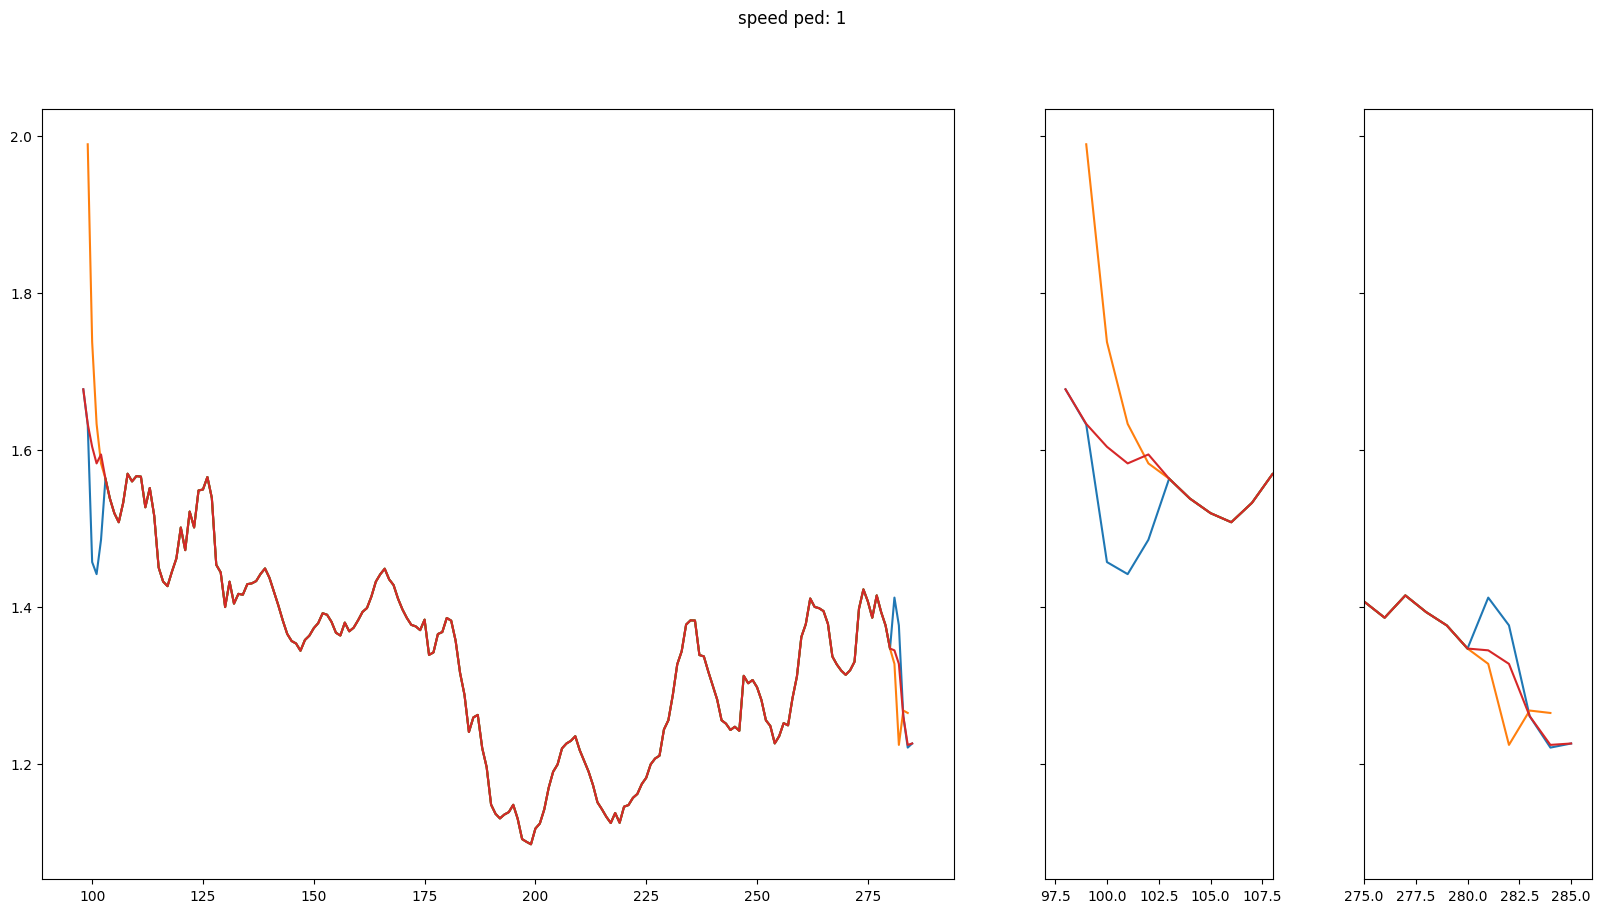

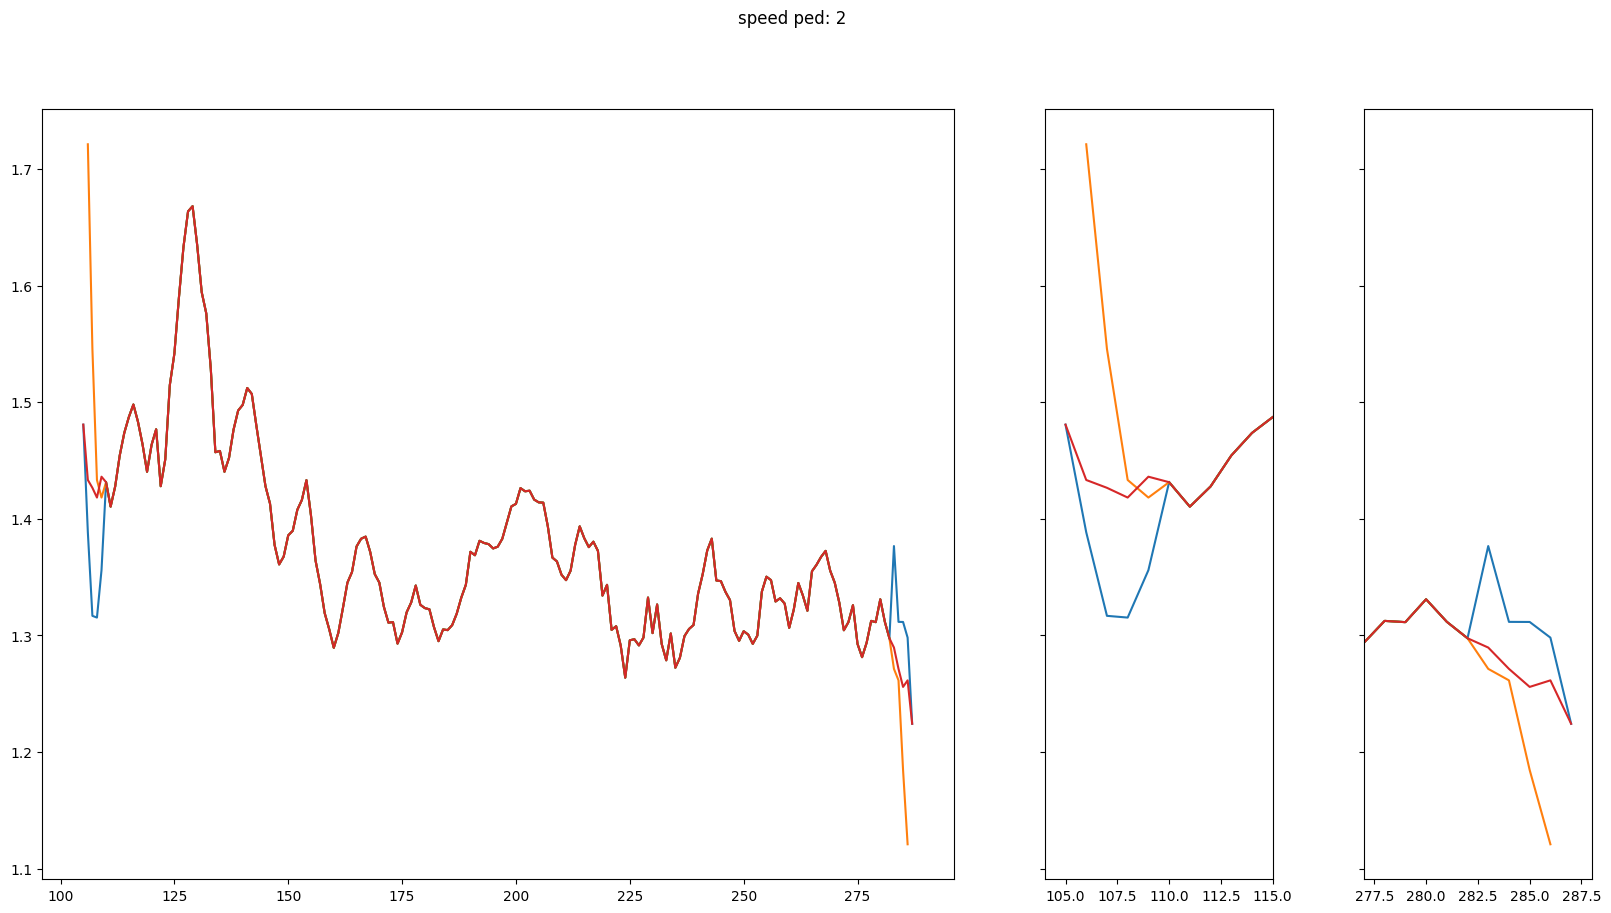

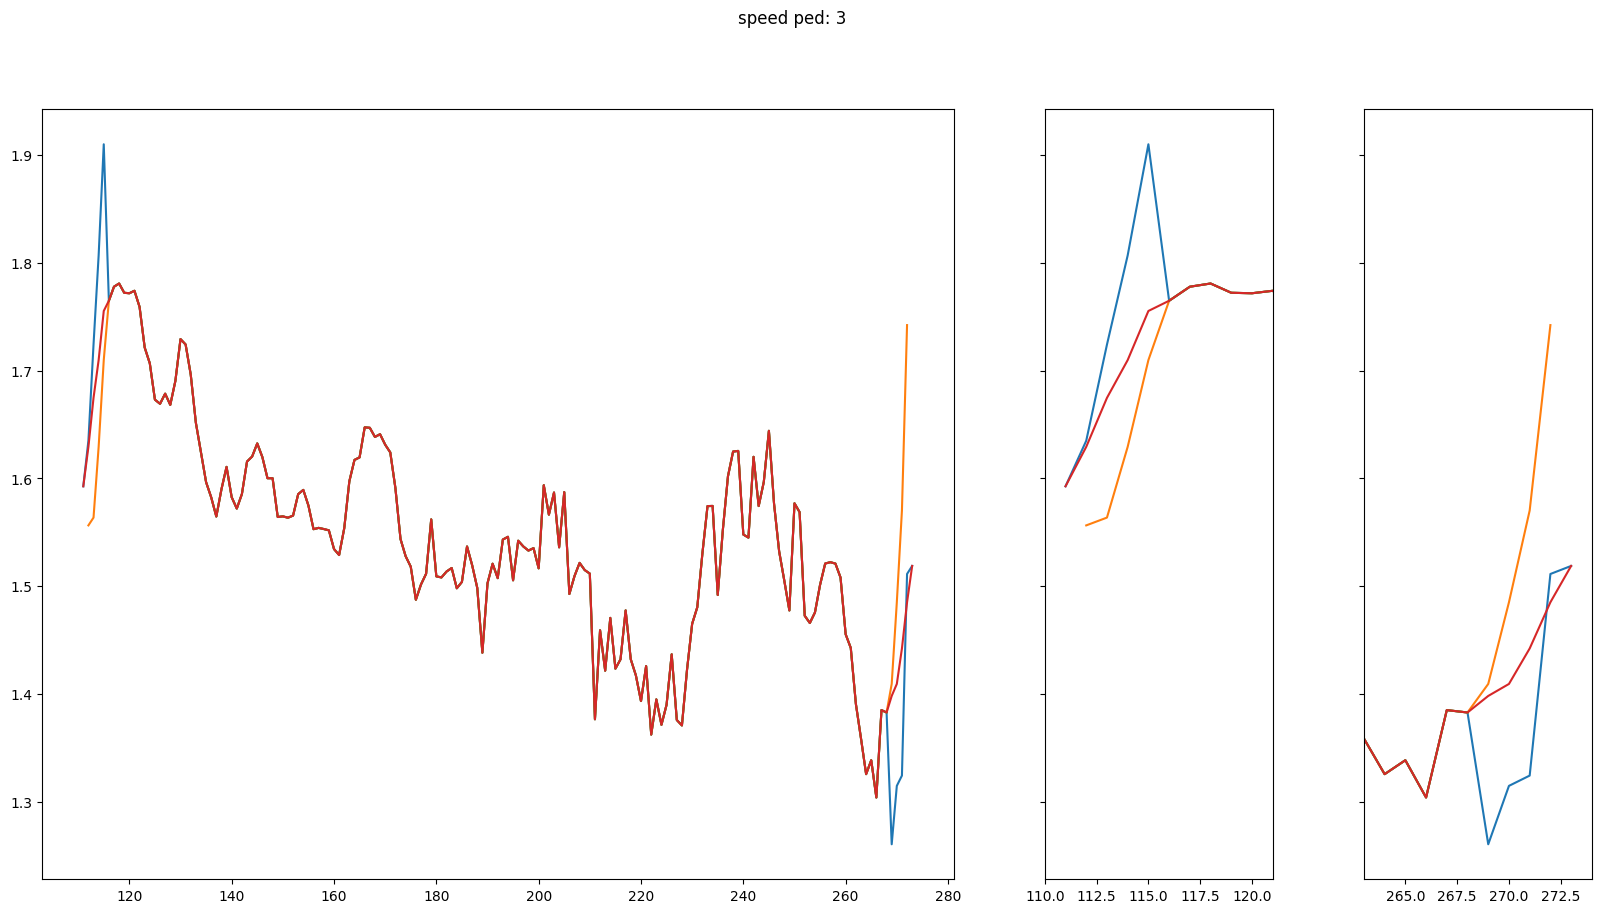

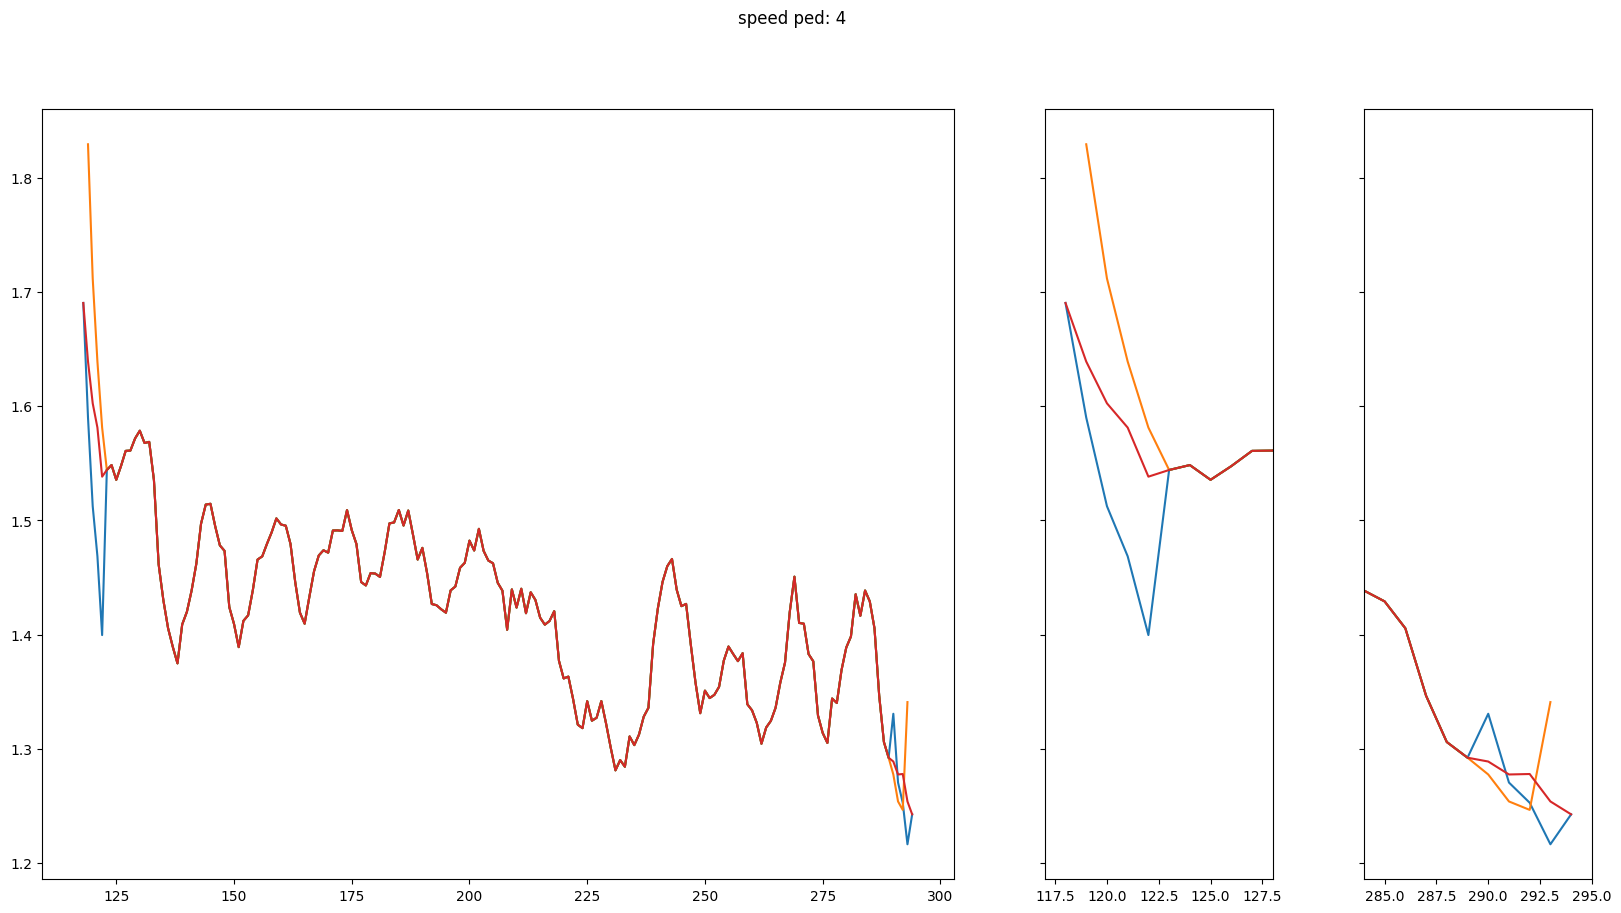

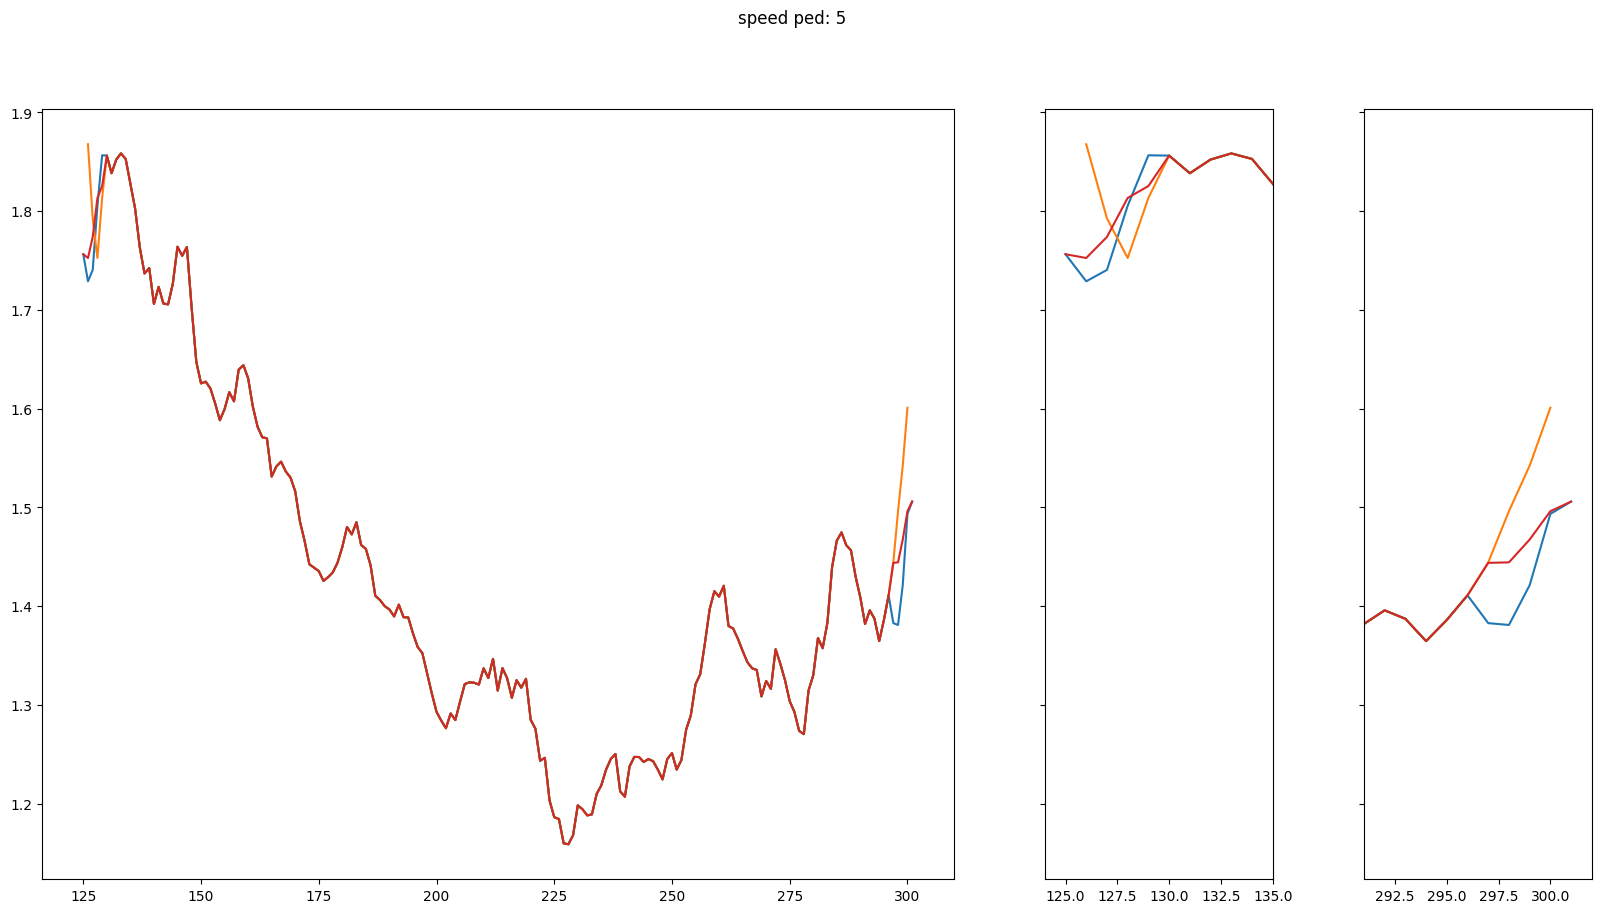

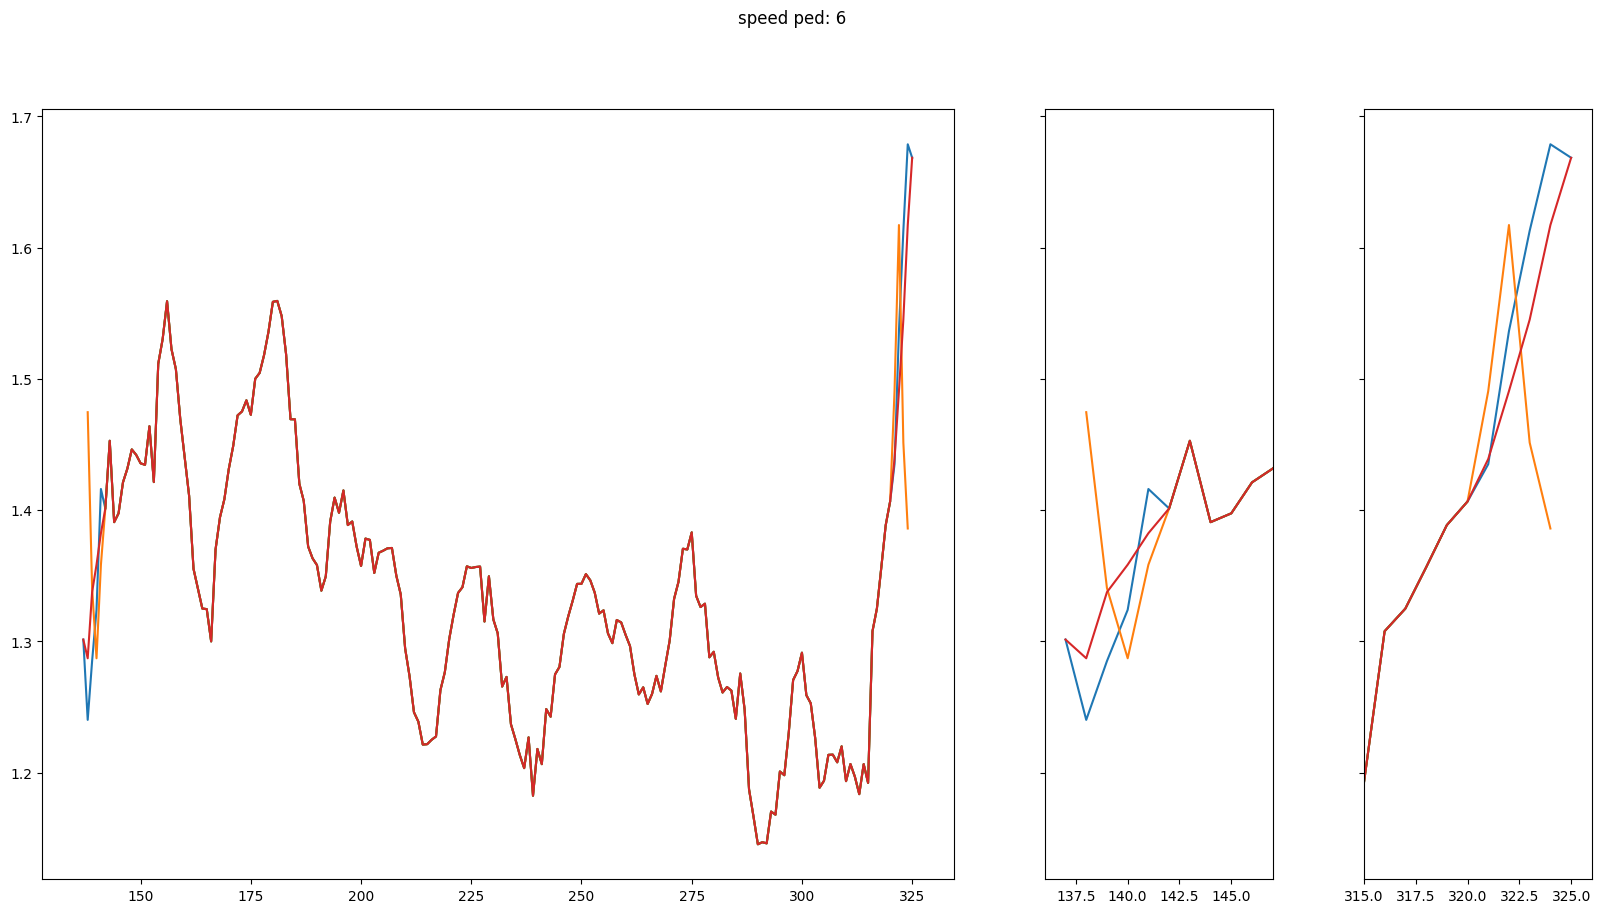

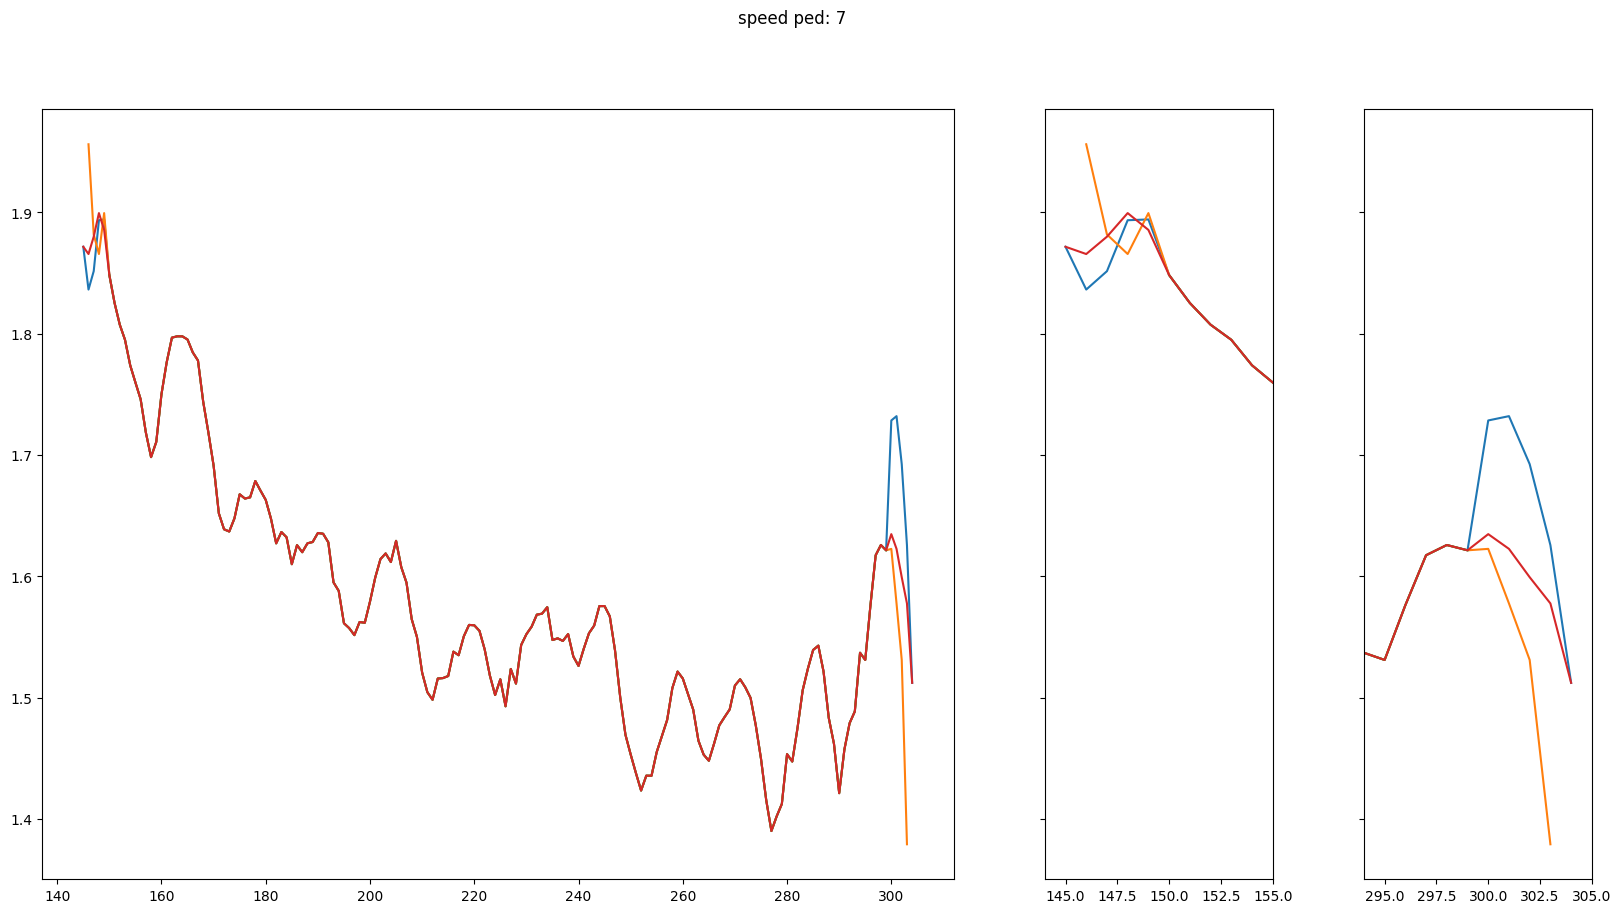

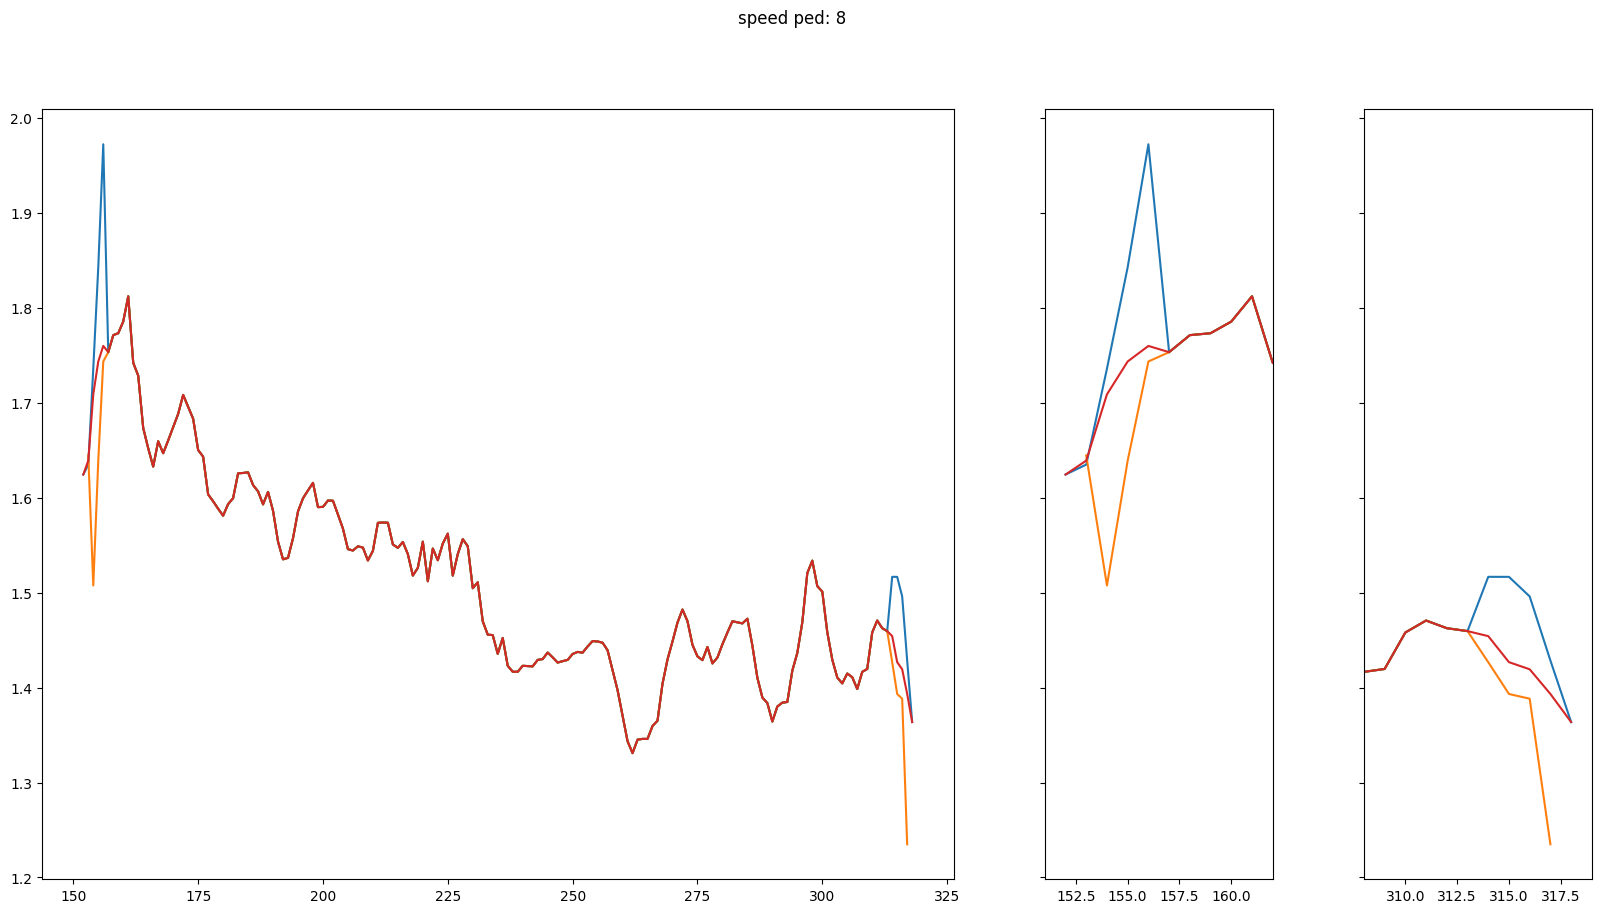

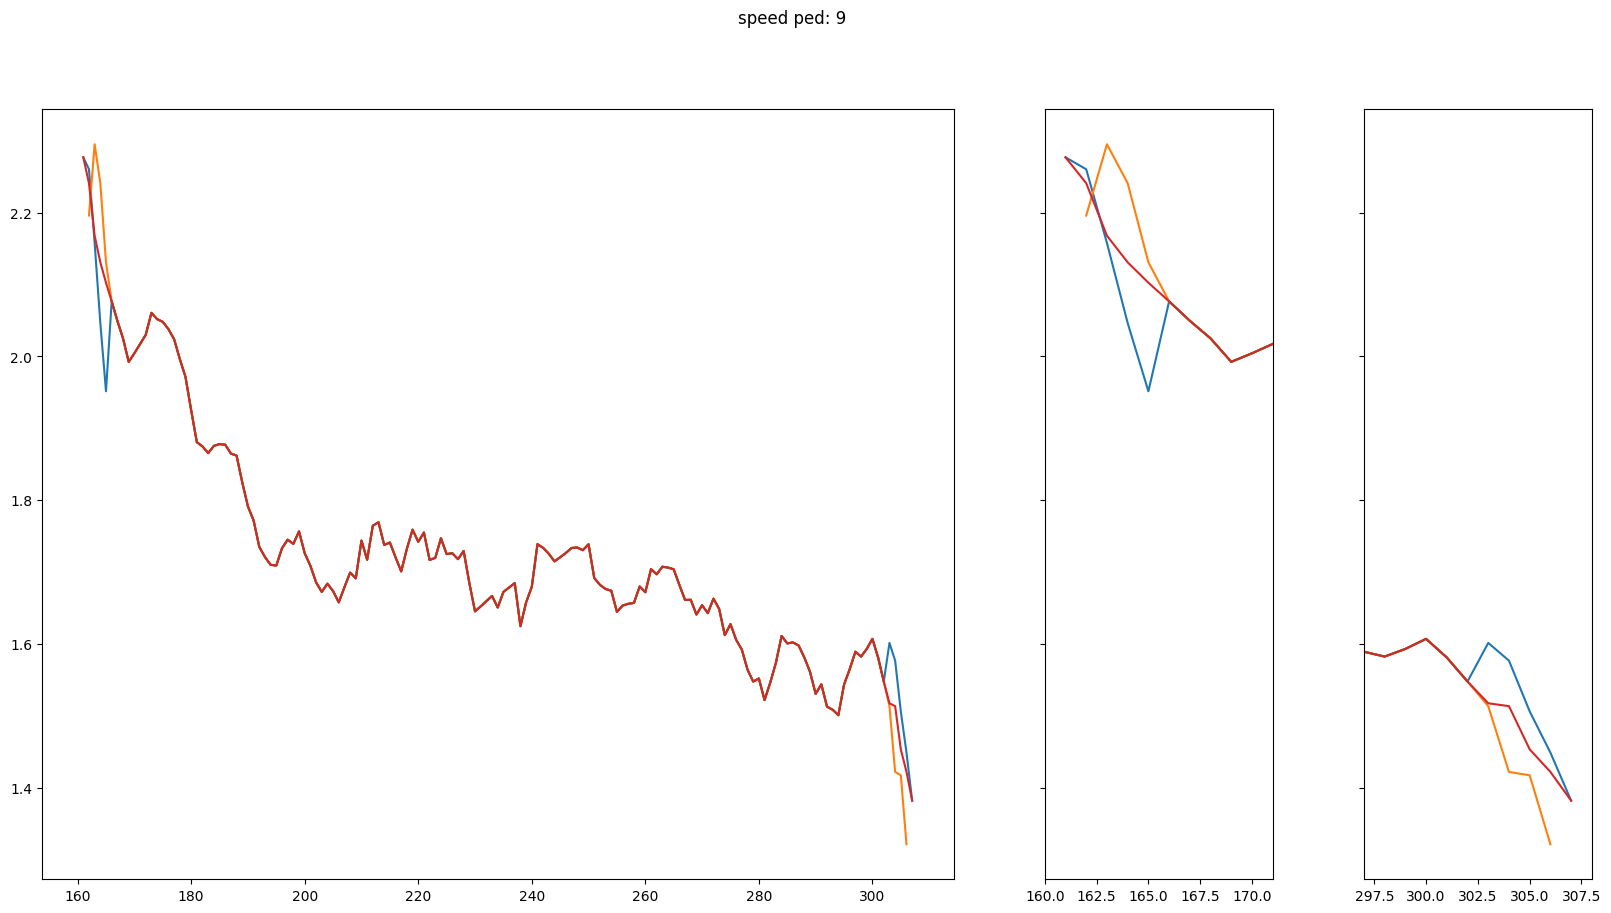

In [78]:
ids = range(1, 10)

for ped_id in ids:
    fig, axs = plt.subplots(
        1, 3, figsize=(20, 10), width_ratios=[8, 2, 2], sharey=True
    )
    fig.suptitle(f"speed ped: {ped_id}")
    axs[0].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="current",
    )
    axs[0].plot(
        adaptive_speed[adaptive_speed.ID == ped_id].frame,
        adaptive_speed[adaptive_speed.ID == ped_id].speed,
        label="adaptive",
    )
    axs[0].plot(
        cutting_speed[cutting_speed.ID == ped_id].frame,
        cutting_speed[cutting_speed.ID == ped_id].speed,
        label="cutting",
    )
    axs[0].plot(
        mixed_speed[mixed_speed.ID == ped_id].frame,
        mixed_speed[mixed_speed.ID == ped_id].speed,
        label="mixed",
    )
    # axs[0].legend()

    axs[1].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="current",
    )
    axs[1].plot(
        adaptive_speed[adaptive_speed.ID == ped_id].frame,
        adaptive_speed[adaptive_speed.ID == ped_id].speed,
        label="adaptive",
    )
    axs[1].plot(
        cutting_speed[cutting_speed.ID == ped_id].frame,
        cutting_speed[cutting_speed.ID == ped_id].speed,
        label="cutting",
    )
    axs[1].plot(
        mixed_speed[mixed_speed.ID == ped_id].frame,
        mixed_speed[mixed_speed.ID == ped_id].speed,
        label="mixed",
    )
    axs[1].set_xlim(
        [
            traj.data[traj.data.ID == ped_id].frame.min() - 1,
            traj.data[traj.data.ID == ped_id].frame.min() + 2 * frame_step,
        ]
    )

    axs[2].plot(
        current_speed[current_speed.ID == ped_id].frame,
        current_speed[current_speed.ID == ped_id].speed,
        label="current",
    )
    axs[2].plot(
        adaptive_speed[adaptive_speed.ID == ped_id].frame,
        adaptive_speed[adaptive_speed.ID == ped_id].speed,
        label="adaptive",
    )
    axs[2].plot(
        cutting_speed[cutting_speed.ID == ped_id].frame,
        cutting_speed[cutting_speed.ID == ped_id].speed,
        label="cutting",
    )
    axs[2].plot(
        mixed_speed[mixed_speed.ID == ped_id].frame,
        mixed_speed[mixed_speed.ID == ped_id].speed,
        label="mixed",
    )
    axs[2].set_xlim(
        [
            traj.data[traj.data.ID == ped_id].frame.max() - 2 * frame_step,
            traj.data[traj.data.ID == ped_id].frame.max() + 1,
        ]
    )

    # handles, labels = axs[0].get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center')
    # plt.show()

# Enhanced comparison

## Computation

Compute the movement and speed for different frame steps with the different methods

In [137]:
frame_steps = [5, 10, 15, 25, 50]

mixed = {}
adaptive = {}
current = {}

mixed_speed = {}
adaptive_speed = {}
current_speed = {}

for frame_step in frame_steps:
    mixed[frame_step] = compute_movement_mixed(traj_data=traj.data, frame_step=frame_step)
    mixed_speed[frame_step] = _compute_individual_speed(
        movement_data=mixed[frame_step], frame_rate=traj.frame_rate
    )

    adaptive[frame_step] = compute_movement_adaptive(traj_data=traj.data, frame_step=frame_step)
    adaptive_speed[frame_step] = _compute_individual_speed(
        movement_data=adaptive[frame_step], frame_rate=traj.frame_rate
    )

    current[frame_step] = compute_movement_current(traj_data=traj.data, frame_step=frame_step)
    current_speed[frame_step] = _compute_individual_speed(
        movement_data=current[frame_step], frame_rate=traj.frame_rate
    )

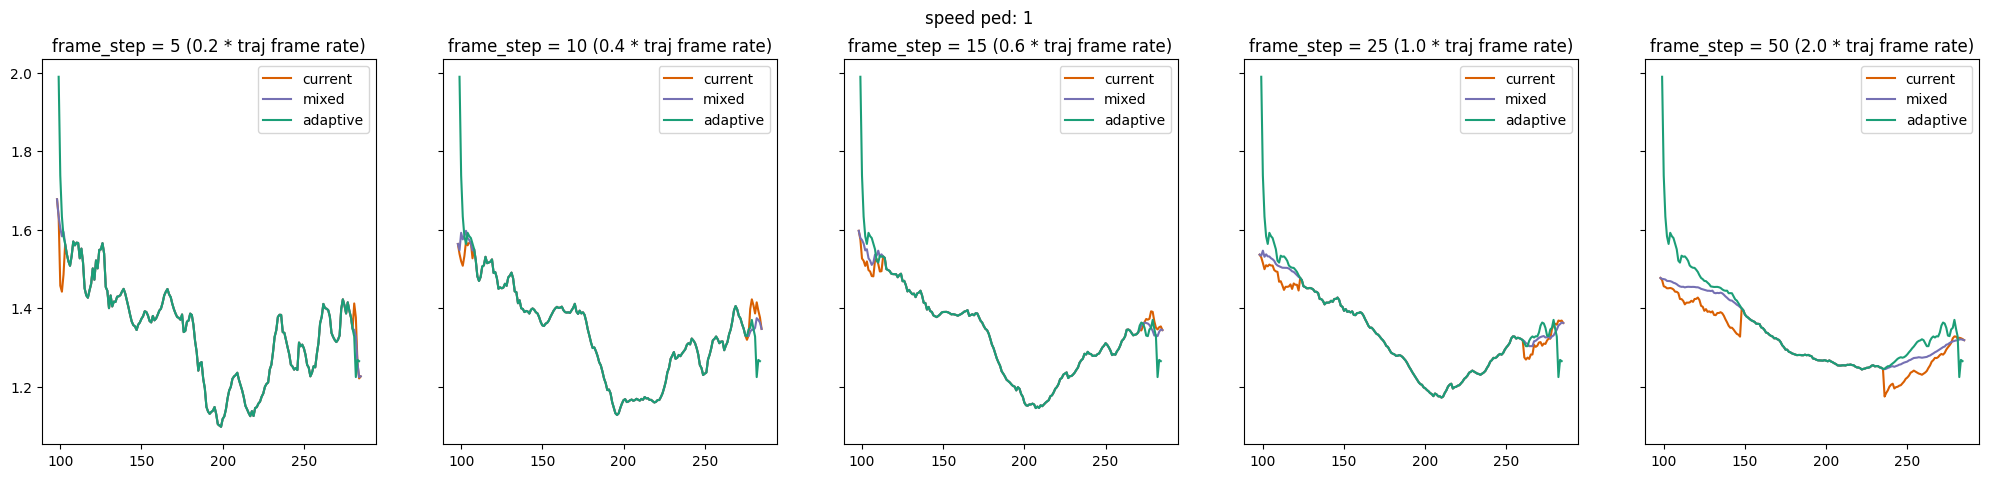

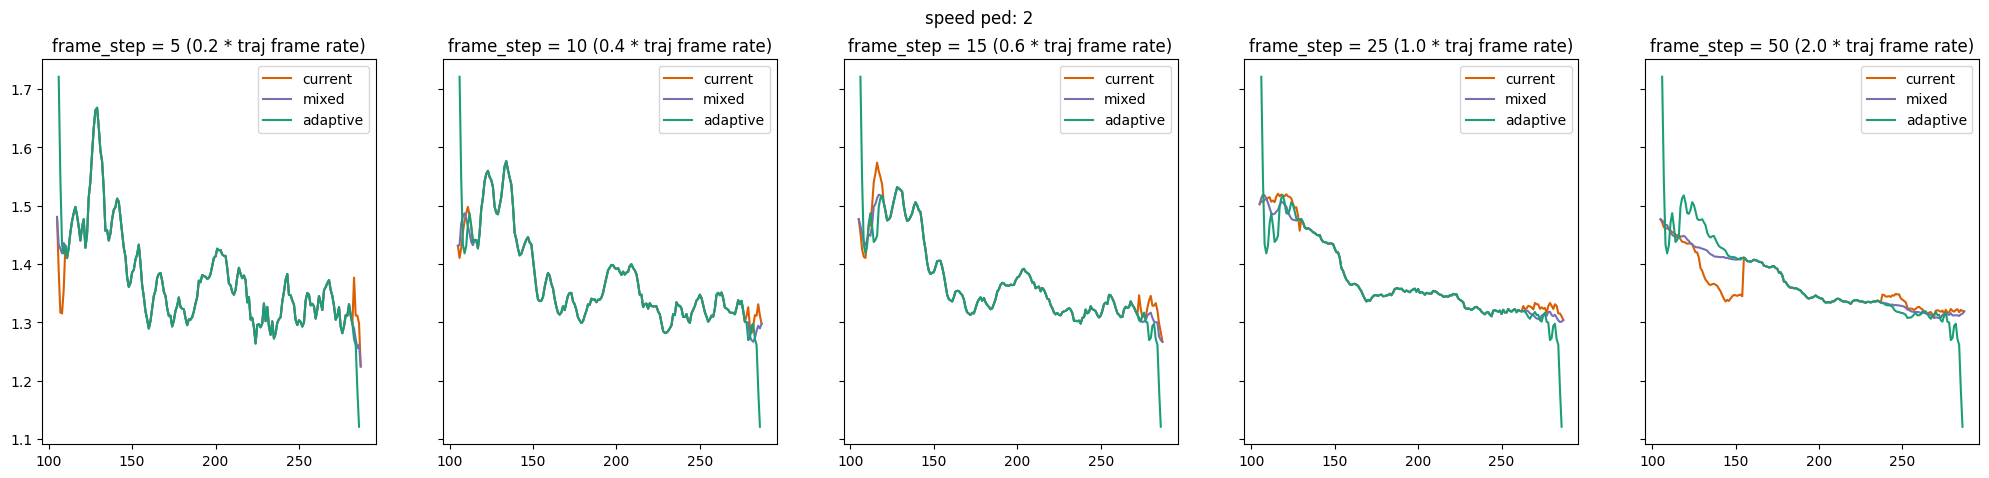

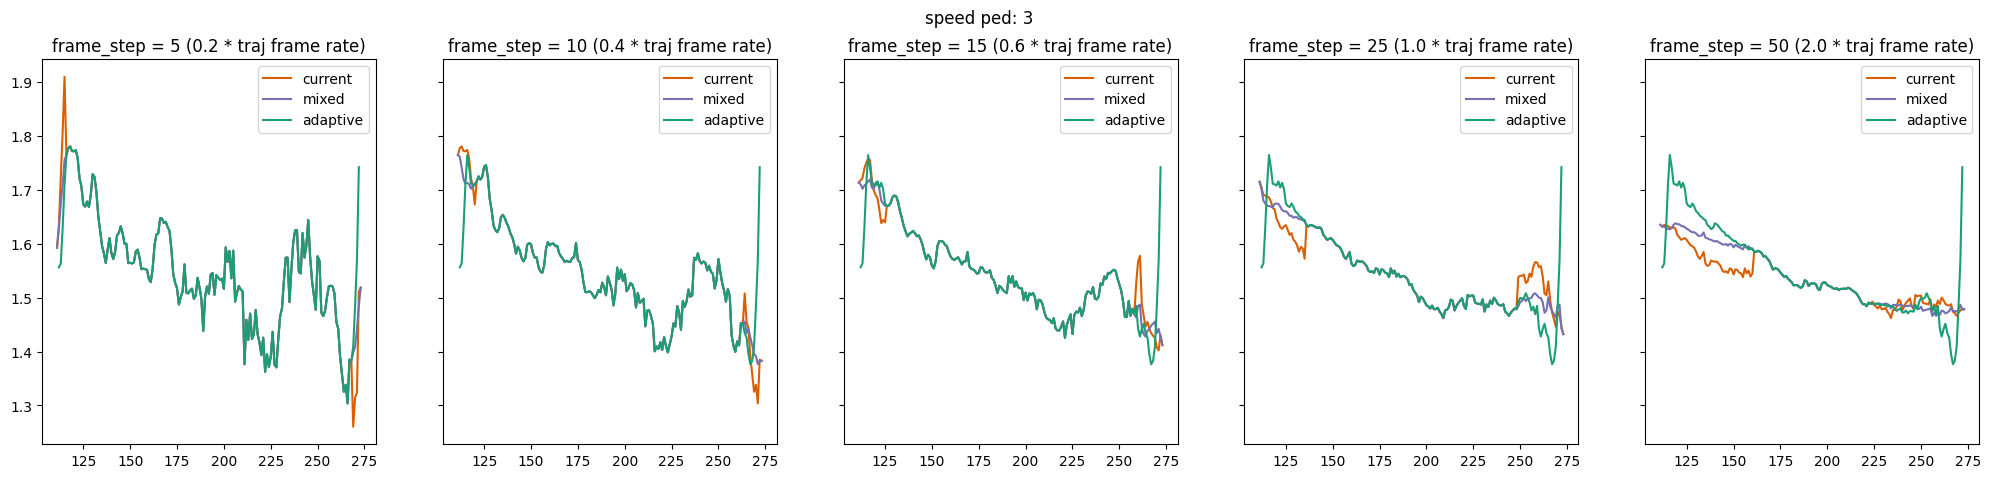

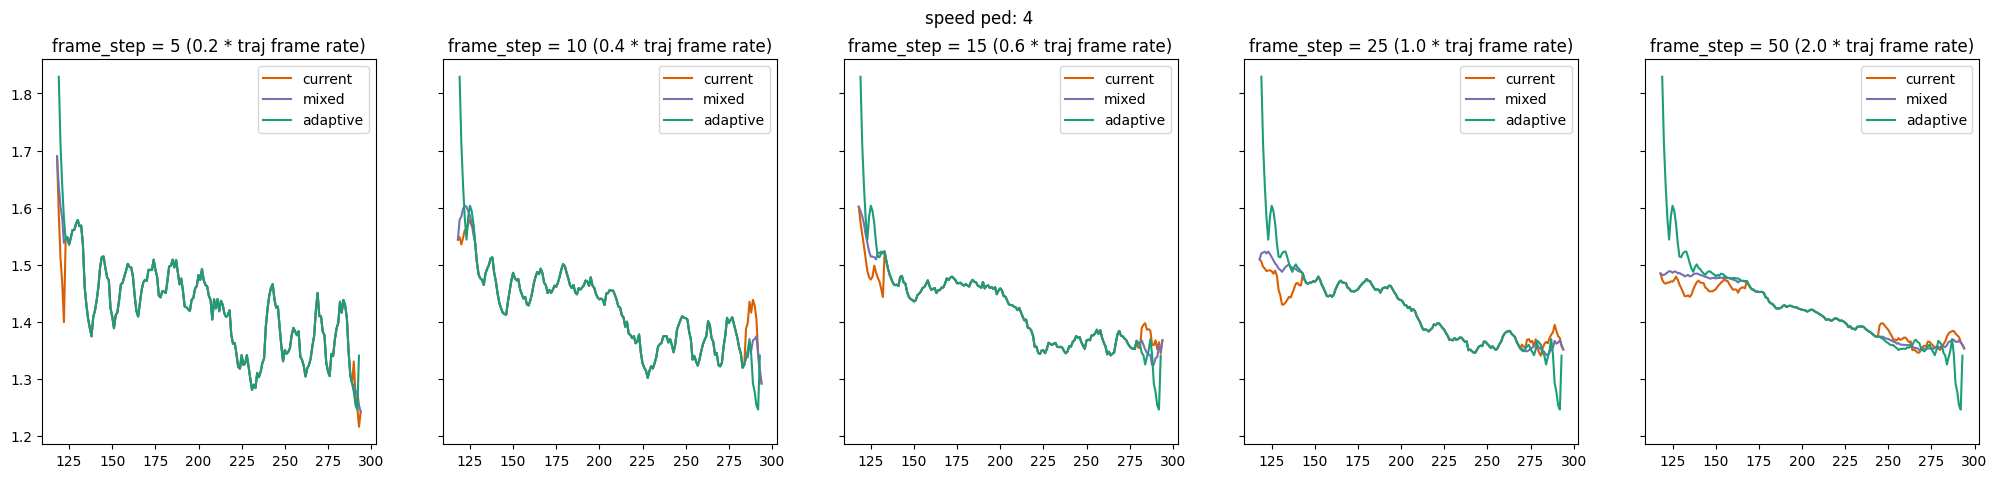

In [138]:
ids = range(1, 5)

for ped_id in ids:
    fig, axs = plt.subplots(
        1, len(current_speed.keys()), figsize=(25, 5), sharey=True
    )
    fig.suptitle(f"speed ped: {ped_id}")

    for ax, fs in zip(axs, current_speed.keys()):
        ax.set_title(f'frame_step = {fs} ({fs/traj.frame_rate} * traj frame rate)')
        current_speed_data = current_speed[fs]
        ax.plot(
            current_speed_data[current_speed_data.ID == ped_id].frame,
            current_speed_data[current_speed_data.ID == ped_id].speed,
            label=f"current",
            color = '#d95f02', #'red',
        )

        mixed_speed_data = mixed_speed[fs]
        ax.plot(
            mixed_speed_data[mixed_speed_data.ID == ped_id].frame,
            mixed_speed_data[mixed_speed_data.ID == ped_id].speed,
            label=f"mixed",
            color = '#7570b3', #'green',
        )

        adaptive_speed_data = adaptive_speed[fs]
        ax.plot(
            adaptive_speed_data[adaptive_speed_data.ID == ped_id].frame,
            adaptive_speed_data[adaptive_speed_data.ID == ped_id].speed,
            label=f"adaptive",
            color = '#1b9e77', #'blue',
        )
        ax.legend()
